# 1. data and package loading

In [1]:
from tensorflow.keras.datasets import cifar10
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical 
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras import optimizers 
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint 
import keras

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0   
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


def create_cnn3():  # kaiming he initialization  https://paperswithcode.com/method/he-initialization
    model = Sequential([
              Conv2D(32, (3,3), activation='relu',input_shape=(32,32,3)),
              MaxPooling2D((2,2)),
              Conv2D(64, (3,3), activation='relu',),
              MaxPooling2D((2,2)),
              Conv2D(64, (3,3), activation='relu',),
              Flatten(),
              Dense(64, activation='relu',),
              Dense(10, activation='softmax')
              ])
    return model

2023-05-01 20:29:27.060535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. the class of ChangeLROnPlateau

In [2]:
import tensorflow as tf 
from keras import backend
import numpy as np
from LRBench.lr.LRfunctions import getLRFunction 


# demo
LR_func_list = np.array([ {'lrPolicy': 'TRI',  'k0': 0.06, 'k1': 0.3, 'l': 500},
                          {'lrPolicy': 'TRI',  'k0': 0.05, 'k1': 0.2, 'l': 500},  
                          {'lrPolicy': 'TRI',  'k0': 0.03, 'k1': 0.15, 'l': 500}, 
                          {'lrPolicy': 'TRI',  'k0': 0.02, 'k1': 0.1, 'l': 500},  
                          {'lrPolicy': 'TRI',  'k0': 0.01, 'k1': 0.05, 'l': 500},  
                          {'lrPolicy': 'TRI2', 'k0': 0.005, 'k1': 0.025, 'l': 3000},  
                          {'lrPolicy': 'TRI2', 'k0': 0.003, 'k1': 0.015, 'l': 3000}, 
                          {'lrPolicy': 'TRI2', 'k0': 0.001, 'k1': 0.005, 'l': 3000}, 
                          {'lrPolicy': 'TRI2', 'k0': 0.0005, 'k1': 0.0025, 'l': 4000},
                          {'lrPolicy': 'TRI2', 'k0': 0.0003, 'k1': 0.0015, 'l': 4000},
                          {'lrPolicy': 'TRI2', 'k0': 0.0001, 'k1': 0.0005, 'l': 4000} ])


class ChangeLROnPlateau(tf.keras.callbacks.Callback):     
    def __init__(self, LR_func_list,start_index, cooldown=5, threshold=0.05,    
                 monitor='var_loss', metric_detection_iter=5): 
        super().__init__()  

        self.LR_func_list = LR_func_list
        self.current_index = start_index
        self.cooldown = cooldown 
        self.cooldown_count = 0 
        self.threshold = threshold
        self.monitor = monitor 
        self.metric_detection_iter = metric_detection_iter 
   
    def on_train_begin(self, logs=None): # clean cache and set monitor_op 
        if 'loss' in self.monitor:
            self.monitor_op = lambda a, b: np.less(max(np.diff(a[::-1])), b) 
            if 'val' in self.monitor: self.monitor = 'val_loss'
            else:                     self.monitor = 'loss'
        if 'acc' in self.monitor:
            self.monitor_op = lambda a, b: np.less(max(np.diff(a)), b) # the diff of acc      
            if 'val' in self.monitor: self.monitor = 'val_accuracy'
            else:                     self.monitor = 'accuracy' 
        
        self.total_iter = self.params['epochs'] * self.params['steps'] 
        self.metric_lst = []
        self.iter_lst = []
        self.action_lst = []
        self.lr_lst = []
        

    def on_train_batch_begin(self, batch, logs=None): # input new iter to get the new lr from current LR function  
        iter = int(self.model._train_counter) + 1
        new_lr = getLRFunction(**LR_func_list[self.current_index])(iter)
        backend.set_value(self.model.optimizer.lr, new_lr)
       
        self.iter_lst.append(iter)
        self.lr_lst.append(new_lr)


    def on_epoch_end(self, epoch, logs=None):  # choose the new LR function   
        current = logs.get(self.monitor)
        self.metric_lst.append(current) 
        
        action = self.is_trapped_on_plateau_action()  
        self.action_lst.append(action)

        if (action == 'increase') & (self.current_index>0):
            self.current_index -= 1
        elif (action == 'decrease') & (self.current_index<len(LR_func_list)-1):
            self.current_index += 1
        else:
            pass         

    def is_trapped_on_plateau_action(self): 
        if (self.is_trapped_on_plateau()) & (self.cooldown_count == 0):
            self.cooldown_count = self.cooldown
            if self.model._train_counter / self.total_iter < 0.8:   # increase when hit the threshold
                return 'increase'    
            else:                              # flip at the end of training, decrease when hit the threshold
                return 'decrease' 
        else:
            if self.cooldown_count > 0:
                self.cooldown_count -= 1
            return 'no action'               


    def is_trapped_on_plateau(self): 
        # loss metric: if the diff of loss_rev is smaller than threshold, the model is trapped on the plateau
        # acc metric: if the diff of acc is smaller than threshold, the model is trapped on the plateau
        if len(self.metric_lst)>self.metric_detection_iter:
            latest_n_metrics = self.metric_lst[-self.metric_detection_iter:]
            if self.monitor_op(latest_n_metrics, self.threshold):
                return True
            else:
                return False  
        else:
            return False    


    def get_monitor_result(self):
        return {'iteration': self.iter_lst, 
                'learning rate': self.lr_lst, 
                'action': self.action_lst, 
                'metric': self.metric_lst}
    
    

# 3. contorl group results

In [3]:
%%time 
# making contorl group result table, 10 times for each parameters

df = pd.DataFrame()

for factor in [0.05, 0.1, 0.2]:
    for patience in [2,5,10]:
        lst_acc = []
        lst_loss = []
        lst_best_epoch = []
        for i in range(0, 5): 
            model = create_cnn3() 
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  
            reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=factor, patience=patience, min_lr=0)  
            model_checkpoint = ModelCheckpoint('./model folder/model_{epoch:02d}.h5',
                                               monitor='val_accuracy', verbose=0, mode='auto')

            history = model.fit(x_train, y_train, callbacks=[[reduce_lr, model_checkpoint]],
                              epochs=30, batch_size=32, 
                              validation_data=(x_test, y_test),
                              verbose=0, 
                              )

            # Get the best model based on validation loss
            best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
            best_model = keras.models.load_model('./model folder/model_{:02d}.h5'.format(best_epoch+1))
            
            validation_score = best_model.evaluate(x_test, y_test, verbose=0) 
            lst_loss.append(validation_score[0])
            lst_acc.append(validation_score[1])
            lst_best_epoch.append(best_epoch+1)

        col = "reducelr_factor_"+str(factor)+"_patience_"+str(patience)+'.acc'
        df[col]  = lst_acc
        col = "reducelr_factor_"+str(factor)+"_patience_"+str(patience)+'.loss'
        df[col] = lst_loss
        col = "reducelr_factor_"+str(factor)+"_patience_"+str(patience)+'.best_epoch'
        df[col]  = lst_best_epoch
df

CPU times: user 1d 3h 32min 36s, sys: 1h 26min 7s, total: 1d 4h 58min 44s
Wall time: 5h 46min 53s


,reducelr_factor_0.05_patience_2.acc,reducelr_factor_0.05_patience_2.loss,reducelr_factor_0.05_patience_2.best_epoch,reducelr_factor_0.05_patience_5.acc,reducelr_factor_0.05_patience_5.loss,reducelr_factor_0.05_patience_5.best_epoch,reducelr_factor_0.05_patience_10.acc,reducelr_factor_0.05_patience_10.loss,reducelr_factor_0.05_patience_10.best_epoch,reducelr_factor_0.1_patience_2.acc,...,reducelr_factor_0.1_patience_10.best_epoch,reducelr_factor_0.2_patience_2.acc,reducelr_factor_0.2_patience_2.loss,reducelr_factor_0.2_patience_2.best_epoch,reducelr_factor_0.2_patience_5.acc,reducelr_factor_0.2_patience_5.loss,reducelr_factor_0.2_patience_5.best_epoch,reducelr_factor_0.2_patience_10.acc,reducelr_factor_0.2_patience_10.loss,reducelr_factor_0.2_patience_10.best_epoch
0,0.7390,0.829825,16,0.7287,0.981880,18,0.7303,1.092659,21,0.7330,...,18,0.7443,0.822947,15,0.7255,1.077749,18,0.7130,0.912291,13
1,0.7331,0.932161,23,0.7352,0.953764,18,0.7215,0.875328,12,0.7356,...,13,0.7355,0.858166,22,0.7335,0.937965,17,0.7148,0.898794,13
2,0.7359,0.795841,19,0.7278,1.161951,27,0.7184,1.102407,19,0.7326,...,25,0.7364,0.926989,17,0.7233,1.037409,19,0.7153,0.882106,10
3,0.7424,0.836896,17,0.7314,0.957598,16,0.7175,0.954736,15,0.7379,...,21,0.7348,0.914083,26,0.7315,0.905899,14,0.7147,1.256469,21
4,0.7315,0.888074,15,0.7266,0.994826,28,0.7152,0.893623,12,0.7276,...,14,0.7388,0.858547,19,0.7216,1.075620,19,0.7223,1.218126,20


# 4. the preformance of ChangeLROnPlateau

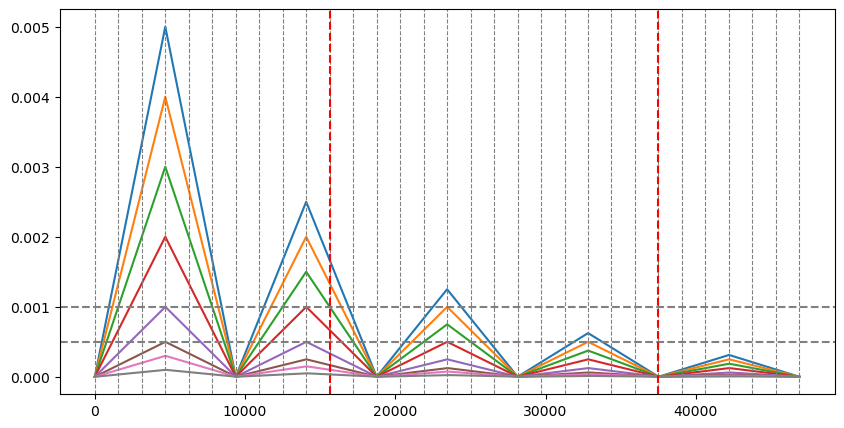

In [4]:
# check the lr functions

k0_factor = 0
k1_factor = 0.2
l_factor = 3

LR_func_list = np.array([{'lrPolicy': 'TRI2', 'k0': 0, 'k1': 0.005, 'l': 1563*l_factor},
                         {'lrPolicy': 'TRI2', 'k0': 0, 'k1': 0.004, 'l': 1563*l_factor}, 
                         {'lrPolicy': 'TRI2', 'k0': 0, 'k1': 0.003, 'l': 1563*l_factor}, 
                         {'lrPolicy': 'TRI2', 'k0': 0, 'k1': 0.002, 'l': 1563*l_factor}, 
                         {'lrPolicy': 'TRI2', 'k0': 0, 'k1': 0.001, 'l': 1563*l_factor}, 
                         {'lrPolicy': 'TRI2', 'k0': 0, 'k1': 0.0005, 'l': 1563*l_factor},
                         {'lrPolicy': 'TRI2', 'k0': 0, 'k1': 0.0003, 'l': 1563*l_factor},
                         {'lrPolicy': 'TRI2', 'k0': 0, 'k1': 0.0001, 'l': 1563*l_factor}
                        ])

plt.figure(figsize=(10, 5))  
for i in range(0,len(LR_func_list)):
    lst=[]
    for iter in range(0,30*1563+1):
        lst.append(getLRFunction(**LR_func_list[i])(iter)) 
    plt.plot(lst)
    
plt.axhline(y=0.001, linestyle='--', color='gray')
plt.axhline(y=0.001/2, linestyle='--', color='gray')

for i in range(0,31):
    plt.axvline(x=1563*i, linestyle='--', color='gray', linewidth=0.8)
    if i==24 or i==10: 
        plt.axvline(x=1563*i, linestyle='--', color='red')

In [5]:
%%time 
# making treatment group result table, 10 times for each parameters

lst_acc = []
lst_loss = []
lst_best_epoch = []
for i in range(0, 5):
    model = create_cnn3() 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  
    change_lr = ChangeLROnPlateau(start_index=4, LR_func_list=LR_func_list, cooldown=3, 
                                  threshold=0.001, monitor='val_accuracy', metric_detection_iter=3)
    
    model_checkpoint = ModelCheckpoint('./model folder/model_{epoch:02d}.h5',
                                       monitor='val_accuracy', verbose=0, mode='auto')

    history = model.fit(x_train, y_train, callbacks=[[change_lr, model_checkpoint]],
                      epochs=30, batch_size=32, 
                      validation_data=(x_test, y_test),
                      verbose=0, 
                      )

    # Get the best model based on validation loss
    best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
    best_model = keras.models.load_model('./model folder/model_{:02d}.h5'.format(best_epoch+1))

    validation_score = best_model.evaluate(x_test, y_test, verbose=0) 
    lst_loss.append(validation_score[0])
    lst_acc.append(validation_score[1])
    lst_best_epoch.append(best_epoch+1)
    
    
col = "changelr_factor.acc"
df[col]  = lst_acc
col = "changelr_factor.loss"
df[col] = lst_loss
col = "changelr_factor.best_epoch"
df[col]  = lst_best_epoch
df

CPU times: user 3h 2min 31s, sys: 8min 56s, total: 3h 11min 27s
Wall time: 33min 49s


,reducelr_factor_0.05_patience_2.acc,reducelr_factor_0.05_patience_2.loss,reducelr_factor_0.05_patience_2.best_epoch,reducelr_factor_0.05_patience_5.acc,reducelr_factor_0.05_patience_5.loss,reducelr_factor_0.05_patience_5.best_epoch,reducelr_factor_0.05_patience_10.acc,reducelr_factor_0.05_patience_10.loss,reducelr_factor_0.05_patience_10.best_epoch,reducelr_factor_0.1_patience_2.acc,...,reducelr_factor_0.2_patience_2.best_epoch,reducelr_factor_0.2_patience_5.acc,reducelr_factor_0.2_patience_5.loss,reducelr_factor_0.2_patience_5.best_epoch,reducelr_factor_0.2_patience_10.acc,reducelr_factor_0.2_patience_10.loss,reducelr_factor_0.2_patience_10.best_epoch,changelr_factor.acc,changelr_factor.loss,changelr_factor.best_epoch
0,0.7390,0.829825,16,0.7287,0.981880,18,0.7303,1.092659,21,0.7330,...,15,0.7255,1.077749,18,0.7130,0.912291,13,0.7435,0.772876,12
1,0.7331,0.932161,23,0.7352,0.953764,18,0.7215,0.875328,12,0.7356,...,22,0.7335,0.937965,17,0.7148,0.898794,13,0.7403,0.786842,12
2,0.7359,0.795841,19,0.7278,1.161951,27,0.7184,1.102407,19,0.7326,...,17,0.7233,1.037409,19,0.7153,0.882106,10,0.7363,0.852379,18
3,0.7424,0.836896,17,0.7314,0.957598,16,0.7175,0.954736,15,0.7379,...,26,0.7315,0.905899,14,0.7147,1.256469,21,0.7447,0.777714,12
4,0.7315,0.888074,15,0.7266,0.994826,28,0.7152,0.893623,12,0.7276,...,19,0.7216,1.075620,19,0.7223,1.218126,20,0.7415,0.792938,12


# 4. result comparison

In [6]:
# acc
filtered_columns = [col for col in df.columns if 'acc' in col]
arr = df[filtered_columns].to_numpy()
arr = np.transpose(arr)
for i in range(0, len(arr)-1): 
    print(arr[i],"- max: {:.5f}".format(np.round(np.max(arr[i]),6)),
                 "- mean: {:.5f}".format(np.round(np.mean(arr[i]),6))) 
print(arr[-1],"- max: {:.5f}".format(np.round(np.max(arr[-1]),6)),
              "- mean: {:.5f}".format(np.round(np.mean(arr[-1]),6)),
              '< ChangeLROnPlateau result')

[0.73900002 0.7331     0.73589998 0.74239999 0.73150003] - max: 0.74240 - mean: 0.73638
[0.72869998 0.73519999 0.72780001 0.73140001 0.72659999] - max: 0.73520 - mean: 0.72994
[0.73030001 0.72149998 0.7184     0.71749997 0.71520001] - max: 0.73030 - mean: 0.72058
[0.73299998 0.73559999 0.73259997 0.73790002 0.72759998] - max: 0.73790 - mean: 0.73334
[0.72469997 0.72939998 0.72240001 0.71380001 0.72430003] - max: 0.72940 - mean: 0.72292
[0.71149999 0.71420002 0.72670001 0.71869999 0.71950001] - max: 0.72670 - mean: 0.71812
[0.74430001 0.73549998 0.73640001 0.73479998 0.73879999] - max: 0.74430 - mean: 0.73796
[0.72549999 0.7335     0.72329998 0.73150003 0.7216    ] - max: 0.73350 - mean: 0.72708
[0.713      0.7148     0.71530002 0.71469998 0.72229999] - max: 0.72230 - mean: 0.71602
[0.74349999 0.7403     0.73629999 0.74470001 0.74150002] - max: 0.74470 - mean: 0.74126 < ChangeLROnPlateau result


In [7]:
# loss
filtered_columns = [col for col in df.columns if 'loss' in col]
arr = df[filtered_columns].to_numpy()
arr = np.transpose(arr)
for i in range(0, len(arr)-1): 
    print(arr[i],"- min: {:.5f}".format(np.round(np.min(arr[i]),6)),
                 "- mean: {:.5f}".format(np.round(np.mean(arr[i]),6))) 
print(arr[-1],"- min: {:.5f}".format(np.round(np.min(arr[-1]),6)),
              "- mean: {:.5f}".format(np.round(np.mean(arr[-1]),6)),
              '< ChangeLROnPlateau result')

[0.82982469 0.93216133 0.79584056 0.83689636 0.88807404] - min: 0.79584 - mean: 0.85656
[0.98187977 0.95376438 1.16195107 0.95759755 0.99482638] - min: 0.95376 - mean: 1.01000
[1.09265924 0.8753283  1.10240674 0.95473605 0.89362317] - min: 0.87533 - mean: 0.98375
[0.87807655 0.84763408 0.9270665  0.82867432 0.855084  ] - min: 0.82867 - mean: 0.86731
[1.1004523  1.05095625 1.01750922 1.22209966 1.18950391] - min: 1.01751 - mean: 1.11610
[1.00920916 0.9226082  1.2561059  1.17992449 0.88483787] - min: 0.88484 - mean: 1.05054
[0.82294744 0.85816634 0.92698896 0.91408271 0.85854745] - min: 0.82295 - mean: 0.87615
[1.07774937 0.93796486 1.03740931 0.90589911 1.07561982] - min: 0.90590 - mean: 1.00693
[0.91229129 0.89879441 0.88210624 1.25646901 1.21812606] - min: 0.88211 - mean: 1.03356
[0.77287596 0.78684223 0.85237932 0.77771437 0.79293835] - min: 0.77288 - mean: 0.79655 < ChangeLROnPlateau result


In [8]:
# epoch times
filtered_columns = [col for col in df.columns if 'epoch' in col]
arr = df[filtered_columns].to_numpy()
arr = np.transpose(arr)
for i in range(0, len(arr)-1): 
    print(arr[i],"- min: {:.5f}".format(np.round(np.min(arr[i]),6)),
                 "- mean: {:.5f}".format(np.round(np.mean(arr[i]),6))) 
print(arr[-1],"- min: {:.5f}".format(np.round(np.min(arr[-1]),6)),
              "- mean: {:.5f}".format(np.round(np.mean(arr[-1]),6)),
              '< ChangeLROnPlateau result')

[16 23 19 17 15] - min: 15.00000 - mean: 18.00000
[18 18 27 16 28] - min: 16.00000 - mean: 21.40000
[21 12 19 15 12] - min: 12.00000 - mean: 15.80000
[15 22 15 15 28] - min: 15.00000 - mean: 19.00000
[20 20 21 23 22] - min: 20.00000 - mean: 21.20000
[18 13 25 21 14] - min: 13.00000 - mean: 18.20000
[15 22 17 26 19] - min: 15.00000 - mean: 19.80000
[18 17 19 14 19] - min: 14.00000 - mean: 17.40000
[13 13 10 21 20] - min: 10.00000 - mean: 15.40000
[12 12 18 12 12] - min: 12.00000 - mean: 13.20000 < ChangeLROnPlateau result
